# 独立成分分析

**独立成分分析（ICA: Independent Component Analysis）** は、独立成分分析（ICA）とは、 **観測信号を「互いに統計的に独立な成分」に分解する手法** である。

代表的な例として「カクテルパーティ問題」があり、複数のマイクに混ざって届いた音声から、話者ごとの音声を分離する問題として知られている。
また、統計的因果探索のLiNGAMでも用いられている。

主成分分析（PCA）が「無相関な成分」への回転であるのに対し、ICA はより強い "独立性" を基準に回転を求める点に特徴がある。


## 目的

観測されたベクトル $x$（混合信号）を $x = A s$ と分解し、  

- $A$：混合行列  
- $s$：互いに独立な信号（独立成分）

を推定することが ICA の目的。

ここで **$s$ は統計的に独立であること** が仮定される。


## モデル

ICA は混合モデルを前提とする。

$$
x = A s
$$

- $x \in \mathbb{R}^d$：観測信号  
- $s\in \mathbb{R}^d$：独立成分（未知）  
- $A$：正則な混合行列（未知）

ICA の目標は **復元行列$W = A^{-1}$ を求めて $s = Wx$ を得て信号$s$を求める** こと。

ICA が成立するためには次の性質が重要となる。

### ICAの仮定

ICA が識別可能であるためには、以下が必要：

1. 独立成分のうち少なくとも一つは非ガウス
    - ガウス成分のみの場合、どんな直交回転をしても不変であるため識別不能。
2. 混合が線形
    - 基本 ICA は線形混合を仮定する（非線形 ICA は別途理論が必要）。
3. $A$ が可逆
    - 非可逆だと $s$ が一意に復元できない。



## ICA の解法の考え方

ICA では **独立性を最大にする方向（回転）を求める**ことが本質である。

代表的なアプローチには以下のものがある

### 非ガウス性の最大化（FastICA）

独立成分は非ガウス性が強いので、

- 尖度（kurtosis）  
- negentropy（ネゲントロピー）

を最大化する方向を探す。

FastICA の代表的更新式は

$$
w \leftarrow 
\mathbb{E}[x g(w^\top x)] - \mathbb{E}[g'(w^\top x)] w
$$

であり、反復により $w$ を収束させる。

### 相互情報量（Mutual Information）の最小化（Infomax）

独立性の尺度として、  
相互情報量 $I(s_1,\dots,s_d)$ を最小化する方法がある。

$$
I(s_1,\ldots,s_d)
= \sum_{i} H(s_i) - H(s)
$$

独立であれば相互情報量は 0。

### 最大尤度法（ML）

混合モデル $x = As$ の尤度を最大化するアプローチも存在する。


## Pythonでの実装

scikit-learnにはFastICAなどの高速なアルゴリズムが実装されている

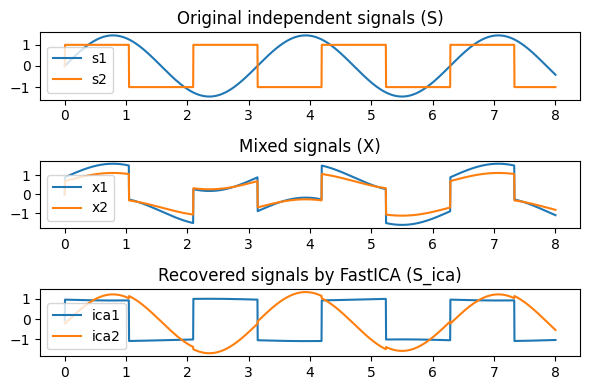

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# -----------------------
# 1) 元の独立信号を作る
# -----------------------
np.random.seed(0)
n_samples = 2000
t = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * t)                          # 独立信号1: 正弦波
s2 = np.sign(np.sin(3 * t))                 # 独立信号2: 矩形波（sign）

S = np.c_[s1, s2]
S /= S.std(axis=0)  # 標準化（ICAの慣習）

# -----------------------
# 2) 混合行列Aで混合する
# -----------------------
A = np.array([[0.5, 0.9],
              [0.3, 0.7]])   # 任意の mixing matrix

X = S @ A.T  # 観測信号（ミックスされた信号）

# -----------------------
# 3) FastICA で分離
# -----------------------
ica = FastICA(n_components=2, random_state=0)
S_ica = ica.fit_transform(X)  # 推定された独立成分
A_est = ica.mixing_           # 推定 mixing matrix
W_est = ica.components_       # unmixing (分離) 行列

# -----------------------
# 4) 図示
# -----------------------
plt.figure(figsize=(6, 4))

plt.subplot(3, 1, 1)
plt.title("Original independent signals (S)")
plt.plot(t, S[:, 0], label="s1")
plt.plot(t, S[:, 1], label="s2")
plt.legend()

plt.subplot(3, 1, 2)
plt.title("Mixed signals (X)")
plt.plot(t, X[:, 0], label="x1")
plt.plot(t, X[:, 1], label="x2")
plt.legend()

plt.subplot(3, 1, 3)
plt.title("Recovered signals by FastICA (S_ica)")
plt.plot(t, S_ica[:, 0], label="ica1")
plt.plot(t, S_ica[:, 1], label="ica2")
plt.legend()

plt.tight_layout()
plt.show()


## Aの推定

混合行列$A$の推定結果

In [70]:
# ======================
# 列の最適割当（Permutation 補正）
# ======================
# Frobenius 距離のコスト行列を作る
cost = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        # A_est の列 j を A の列 i に合わせたときの誤差
        cost[i, j] = np.linalg.norm(A[:, i] - A_est[:, j])

# Hungarian algorithm
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost)

# 列を並べ替え
A_est = A_est[:, col_ind]

print(f"""
予測値：
{A_est.round(2)}

真値：
{A.round(2)}
""")


予測値：
[[0.53 0.93]
 [0.32 0.72]]

真値：
[[0.5 0.9]
 [0.3 0.7]]

